<a href="https://colab.research.google.com/github/Segrey372017/gb_ML_in_business/blob/main/ssmirnov_ml_business_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [37]:
from statsmodels.stats import proportion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Домашняя работа к Уроку 8
<p> Взять датасет из google диска: https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически. </p>

In [2]:
#!wget 'https://drive.google.com/uc?export=download&id=1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_' -O data.zip

--2022-04-19 05:36:01--  https://drive.google.com/uc?export=download&id=1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_
Resolving drive.google.com (drive.google.com)... 173.194.216.113, 173.194.216.138, 173.194.216.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jugf59bsg9jmrbou91e6e109mbph6ovb/1650346500000/14904333240138417226/*/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_?e=download [following]
--2022-04-19 05:36:03--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jugf59bsg9jmrbou91e6e109mbph6ovb/1650346500000/14904333240138417226/*/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0

In [3]:
#!unzip data.zip

Archive:  data.zip
  inflating: marketing description.txt  
  inflating: marketing_campaign.csv  
  inflating: subscribers.csv         
  inflating: users.csv               


In [4]:
DATA_LINK = 'https://raw.githubusercontent.com/Segrey372017/gb_ML_in_business/main/hw8_marketing_campaign.csv' # перенес на свой гит

In [5]:
data = pd.read_csv(DATA_LINK)

In [6]:
data.head()

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True


In [9]:
data.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [10]:
data.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [22]:
data.converted.isna().mean()*100 # 15% данных потеряно

0.14944704593005878

Для анализа потребуются лишь колонки 'variant' и 'converted'). Перенесем эти значения в отдельный датафрейм

In [17]:
U = pd.DataFrame(data = data[['variant', 'converted']])

In [18]:
U.head(3)

,variant,converted
0,personalization,True
1,personalization,True
2,personalization,True


Колонки содержат текстовые категориальные данные. Заменим значения на 0 и 1 для соответствующих категорий

In [19]:
v_rep = {'control': 0, 'personalization': 1 } # для variant
c_rep = {False: 0, True: 1} # для converted

In [20]:
# выполняем замены
U.variant  = U.variant.replace(v_rep)
U.converted = U.converted.replace(c_rep)
U.describe() # проверим

,variant,converted
count,10037.000000,10022.000000
mean,0.492777,0.107364
std,0.499973,0.309591
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [21]:
U.isna().mean()*100

variant      0.000000
converted    0.149447
dtype: float64

In [23]:
# Обработаем пропуски, будем считать, что если нет данных о конверсии значит резултат отрицательный
U.converted = U.converted.fillna(0)

In [24]:
U.isna().mean()*100 # проверка

variant      0.0
converted    0.0
dtype: float64

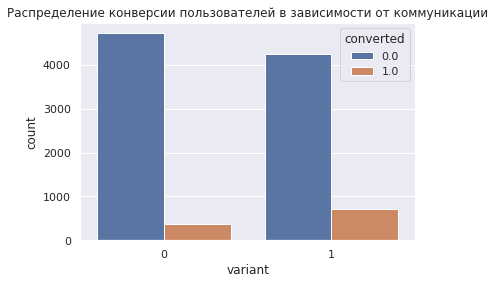

<Figure size 648x432 with 0 Axes>

In [33]:
# посмотрим как визуально распределена конверсия пользователей в зависимости от варианта коммуникации
plt.title('Распределение конверсии пользователей в зависимости от коммуникации')
sns.countplot(x = 'variant', hue = 'converted', data = U)
plt.figure(figsize = (9,6))
plt.show()

На диаграммах есть заметная разница по абсолютному числу конверсионных пользователей среди тех, кто получил персональные рекомендаци (1). Попробуем доказать это аналитически


In [34]:
# Сформируем две группы данных A - контрольная B - персонализированная
A = U.converted.loc[U.variant == 0]
B = U.converted.loc[U.variant == 1]

In [35]:
A.describe()

count    5091.000000
mean        0.072874
std         0.259955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: converted, dtype: float64

In [36]:
B.describe()

count    4946.000000
mean        0.142539
std         0.349638
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: converted, dtype: float64

Средние величины также показывают, что в группе B конверсия выше

In [41]:
# поскольку данны категориальные выполним z-test, чтобы потдвердить (опровергнуть) эффективность персонализированных рекомендаций
k1, n1 = A.sum(), A.count()
k2, n2 = B.sum(), B.count()

In [39]:
# выполним рассчет z- критерия
def get_z_test(k1, n1, k2, n2, alpha = 0.05 ):
    """
    Выполняет z-test для двух групп категориальных признаков
    """
    stat, p_val = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]), value = alpha)
    if p_val < alpha:
        print(f'В группах признаков есть статистически значимые отличия, z_stat= {stat:.5f}, p-value={p_val:.5f}, alpha={alpha}')
    else:
        print(f'В группах признаков нет статистически значимых отличий, z_stat= {stat:.5f}, p-value={p_val:.5f}, alpha={alpha}')

    return stat, p_val

In [42]:
get_z_test(k1, n1, k2, n2)

В группах признаков есть статистически значимые отличия, z_stat= -19.37385, p-value=0.00000, alpha=0.05


(-19.37385193456492, 1.2829100380651665e-83)

<h3> Выводы: </h3> Предположение о том, что персонализированные рекомендации в среднем чаще повышают вероятность совершения пользователем целевого действия (конверсию) подтвердилось.

In [46]:
# в заключение проверим значимость среднестатистических отклонений в рассматриваемых группах
# выполним рассчет z- критерия
def get_xi_test(k1, n1, k2, n2, alpha = 0.05 ):
    """
    Выполняет z-test для двух групп категориальных признаков
    """
    stat, p_val, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                 np.array([n1, n2]), value = alpha)
    if p_val < alpha:
        print(f'В группах признаков есть статистически значимые отличия, xi_square= {stat:.5f}, p-value={p_val:.5f}, alpha={alpha}')
    else:
        print(f'В группах признаков нет статистически значимых отличий, xi_square= {stat:.5f}, p-value={p_val:.5f}, alpha={alpha}')

    return stat, p_val

In [47]:
get_xi_test(k1, n1, k2, n2)

В группах признаков есть статистически значимые отличия, xi_square= 947.76710, p-value=0.00000, alpha=0.05


(947.7671031531988, 1.5667095314505837e-206)

<h3> Вывод: </h3>
<p> Анализ средних величин и дисперсии подтвердил, что группа пользователей с персонализированной рекламой имеет параметры распределения статистически значимо отличающиеся от контрольной группы. Соответсвенно, поскольку средняя конверсия в группе B оказалась выше, подход с персонализированной рекламой оказался эффективнее. </p>